In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter
import spacy
nlp = spacy.load('en')

# Load data

In [2]:
D = pd.read_hdf('data.hdf', 'data')
docs = list(D['docs'])
docs = [d.split(' ') for d in docs]

# Get unigram distribution

In [3]:
tokens = []
for d in docs:
    tokens += d

term_counts = Counter(tokens)

# number of unique words
len(term_counts)

13831

In [4]:
# (term, term_count)
term_counts = [(k, term_counts[k]) for k in term_counts]

In [5]:
# sort by counts 
term_counts = sorted(term_counts, key=lambda x: x[1], reverse=True)

In [6]:
# total number of counts
counts_sum = sum([t[1] for t in term_counts])
counts_sum

1582507

In [7]:
unigram_dist = {i: v[1]/counts_sum for i, v in enumerate(term_counts, 1)}

# Encode documents

In [8]:
# encode words with integers
encode = {v[0]: i for i, v in enumerate(term_counts, 1)}
decode = {i: v[0] for i, v in enumerate(term_counts, 1)}
# 1 - the most common word, 2 - the second most common word, ...

In [37]:
encoded_docs = D['docs'].apply(lambda x: x.split(' ')).apply(lambda x: [encode[w] for w in x])

In [46]:
encoded_docs.head()

0    [85, 2685, 549, 288, 3214, 789, 179, 40, 824, ...
1    [1204, 676, 70, 603, 347, 98, 54, 2159, 217, 4...
2    [755, 11, 1697, 10533, 14, 203, 97, 13, 4, 244...
3    [7, 253, 98, 2687, 756, 140, 253, 98, 2687, 75...
4    [104, 38, 9, 14, 17, 1244, 181, 1043, 109, 127...
Name: docs, dtype: object

# Create windows

In [38]:
hws = 5 # half window_size

In [43]:
# doc: a list of words
def get_windows(doc, hws):
    # it returns a list of tuples,
    # each tuple looks like this:
    # (word w, [hws words that come before w] + [hws words that come after w])
    
    length = len(doc)
    
    if length > 2*hws:
        
        inside = [(w, doc[(i - hws):i] + doc[(i + 1):(i + hws + 1)]) 
                  for i, w in enumerate(doc[hws:-hws], hws)]
        
        # For words that are near the beginning or
        # the end of doc tuples are slightly different
        
        beginning = [(w, doc[:i] + doc[(i + 1):(2*hws + 1)]) 
                     for i, w in enumerate(doc[:hws], 0)]
        
        end = [(w, doc[-(2*hws + 1):i] + doc[(i + 1):]) 
               for i, w in enumerate(doc[-hws:], length - hws)]
        
        return beginning + inside + end
    else:
        print('Error! Not enough words in doc')

In [47]:
windows = encoded_docs.apply(lambda x: get_windows(x, hws))

# Prepare data for lda2vec

In [63]:
data = []
for index, list_of_windows in tqdm(windows.iteritems()):
    # index represents id of a document, 
    # list_of_windows is a list of (word, window around this word),
    # where word is in the document
    data += [[index, w[0]] + w[1] for w in list_of_windows]

16121it [00:02, 7058.10it/s]


In [64]:
data = np.array(data, dtype='int64')

In [69]:
# a row in the data contains:
# id of a document, id of a word in this document, a window around this word
# 1 + 1 + 10
data.shape[1]

12

In [70]:
# number of windows
data.shape[0]

1582507

# Save data

In [72]:
np.save('window_data.npy', data) # ~152 MB

# Prepare word vectors

In [10]:
def has_vector(word):
    return nlp.vocab[word].has_vector

def get_vector(word):
    return nlp.vocab[word].vector

In [15]:
vocab_size = len(decode)
embedding_dim = 300

word_vectors = np.zeros((vocab_size, embedding_dim), 'float32')

In [19]:
len(decode)

13831

In [18]:
no_vec = [t for t in decode.values() if not has_vector(t)]
len(no_vec)

8947

In [10]:
freq = [c[1] for c in term_counts]

In [12]:
import matplotlib.pyplot as plt 

In [13]:
%matplotlib inline

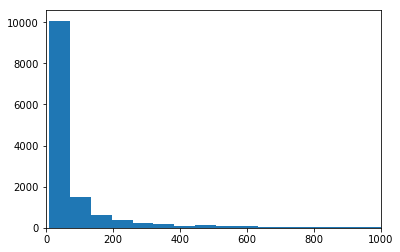

In [22]:
plt.hist(freq, bins=1000);
plt.xlim([0, 1000]);